# Project 5: **Build a Multi-Modal Generation Agent**

Welcome to the final project! In this project, you'll use open-source text-to-image and text-to-video models to generate content. Next, you'll build a **unified multi-modal agent** similar to modern chatbots, where a single agent can support general questions, image generation, and video generation requests.

By the end of this project, you'll understand how to integrate multiple model types under one  routing system capable of deciding what modality to use based on the user's intent.



## Learning Objectives

* Use **Text-to-Image** models to generate images from a text.
* Generate short clips with a **Text-to-Video** model
* Build a **Multi-Modal Agent** that answers questions and routes media requests
* Build a simple **Gradio** UI and interact with the multi-modal agent

## Roadmap
1. Environment setup
2. Text‑to‑Image
3. Text‑to‑Video
4. Multimodal Agent
5. Gradio UI
6. Celebrate

## 1 - Environment Setup

In this project, we'll use open-source Text-to-Image and Text-to-Video models to generate visuals from natural-language prompts. These models are computationally heavy and perform best on GPUs, so we recommend running this notebook in Google Colab or another GPU-enabled environment. We'll load all models from Hugging Face, which requires authentication.

Before continuing:
1. Open this project in Google Colab. [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bytebyteai/ai-eng-projects/blob/main/project_5/multimodal_agent.ipynb)
2. Create a Hugging Face account and generate an access token at huggingface.co/settings/tokens
3. Paste your token in the field below to log in.
4. In the Colab environment, enable GPU acceleration by selecting Runtime → Change runtime type → GPU.

In [ ]:
from huggingface_hub import login

# Replace 'YOUR_HF_TOKEN_HERE' with your actual Hugging Face token
# IMPORTANT: Never commit your actual token to Git!
login(token="YOUR_HF_TOKEN_HERE")

Let's import the required libraries and confirm that PyTorch can detect the available GPU.

In [23]:
import torch, diffusers, transformers, os, random, gc
print('torch', torch.__version__, '| CUDA:', torch.cuda.is_available())

torch 2.9.1 | CUDA: False


## 2 - Text-to-Image (T2I)
T2I models translate natural-language descriptions into images. They are typically based on diffusion models, which gradually refine random noise into a coherent picture guided by the text prompt. In this section, you'll load and test one such model to generate images directly from text inputs.

### 2.1: Load a T2I Model
We'll use `Stable Diffusion XL` (SDXL) by `Stability AI`, one of the open-source diffusion models. It provides high-quality, detailed image generation with relatively efficient inference compared to earlier versions.

You'll load the model from Hugging Face using the diffusers library, which simplifies running diffusion-based pipelines. To learn more about diffusers, read: https://huggingface.co/docs/diffusers/main/index


In [24]:
from diffusers import DiffusionPipeline
# Define the Stable Diffusion XL model ID from Hugging Face and load the pre-trained model

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

# Move to GPU if available (CUDA or MPS for Apple Silicon)
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
elif torch.backends.mps.is_available():
    pipe = pipe.to("mps")
    
print(f"Model loaded on: {pipe.device}")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]


Model loaded on: mps:0


### 2.2: Generate an image

100%|██████████| 50/50 [06:30<00:00,  7.82s/it]


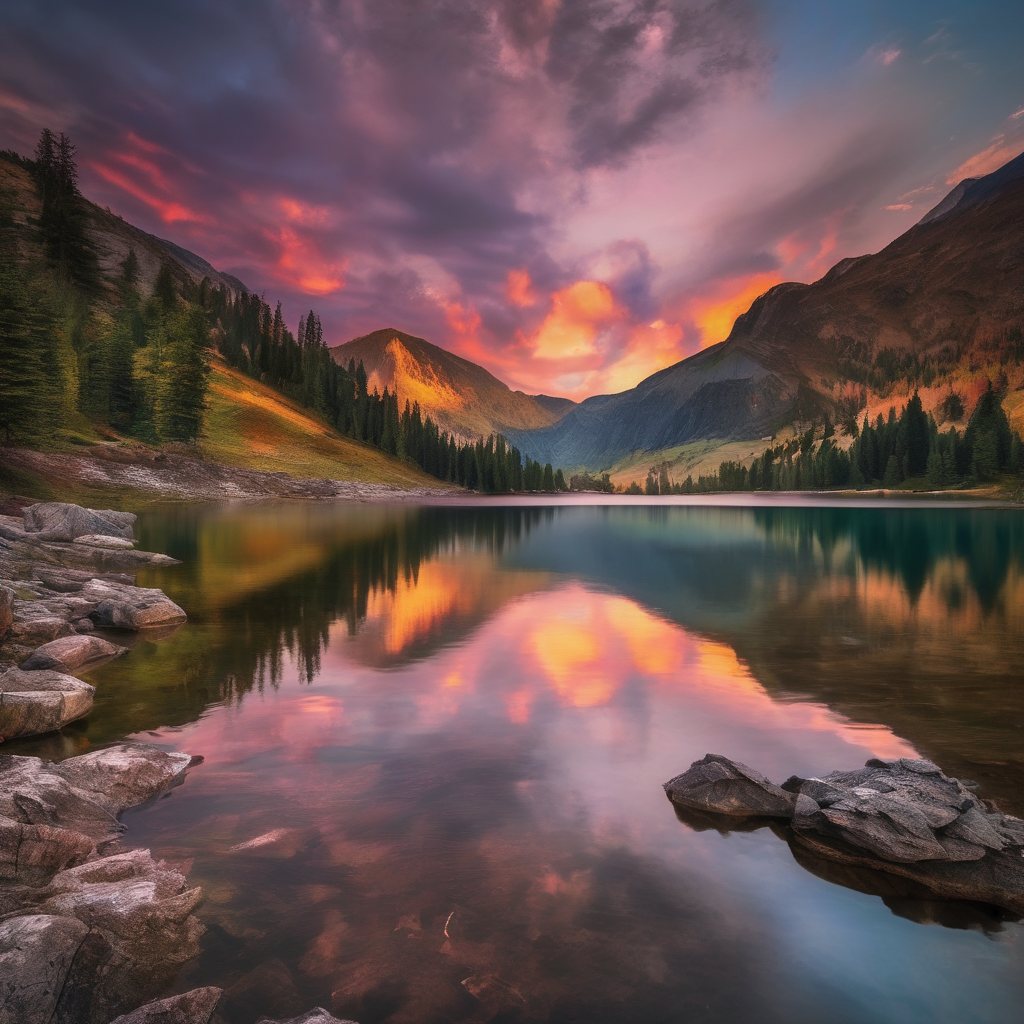

In [4]:
# Generate and display an image from a text prompt using the loaded pipeline
prompt = "A serene mountain landscape at sunset with a lake reflecting the colorful sky"
image = pipe(prompt).images[0]
image

### 2.3: Experimenting with "inference_steps"

The number of inference steps determines how many refinement passes the diffusion model makes. Fewer steps give quicker but less detailed images, while more steps improve clarity and structure at the cost of speed.

Try generating images with different step counts and compare the results.

Matplotlib is building the font cache; this may take a moment.
100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


Generated image with 10 steps


100%|██████████| 25/25 [03:48<00:00,  9.12s/it]


Generated image with 25 steps


100%|██████████| 50/50 [08:46<00:00, 10.54s/it]


Generated image with 50 steps


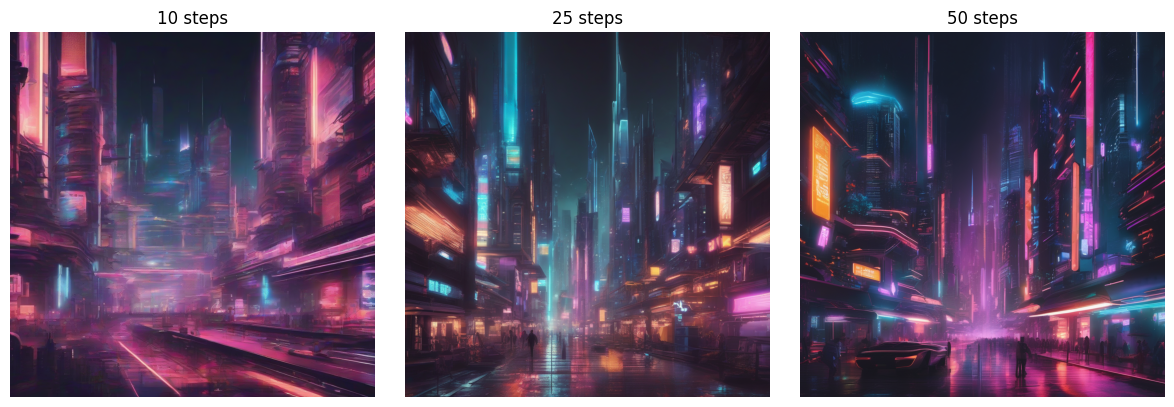

In [5]:
import matplotlib.pyplot as plt

# Generate an image for different values of num_inference_steps (e.g., 10, 25, 50) and compare sharpness and detail
images = []

test_prompt = "A futuristic city at night with neon lights"
step_counts = [10, 25, 50]

for steps in step_counts:
    img = pipe(test_prompt, num_inference_steps=steps).images[0]
    images.append((steps, img))
    print(f"Generated image with {steps} steps")

# Plot results side-by-side
plt.figure(figsize=(12, 4))
for i, (steps, img) in enumerate(images, 1):
    plt.subplot(1, len(images), i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{steps} steps")
plt.tight_layout()
plt.show()

## 3 - Text-to-Video (T2V)
T2V models extend the idea of diffusion from still images to moving sequences. Instead of generating one frame, they create a series of coherent frames that depict motion consistent with the text prompt. These models are computationally heavier and often generate short clips (typically 2-10 seconds).

In this section, you'll load an open-source video diffusion model and prepare it for generation.

### 3.1: Load a T2V model

We'll use the model `damo-vilab/text-to-video-ms-1.7b`, which can produce short video clips from text prompts. This model benefits from a specialized scheduler (DPMSolverMultistepScheduler) that improves stability and speed during sampling.

In [25]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

video_model_id = 'damo-vilab/text-to-video-ms-1.7b'

# Load the model with FP16 precision for efficiency
video_pipe = DiffusionPipeline.from_pretrained(
    video_model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
video_pipe.scheduler = DPMSolverMultistepScheduler.from_config(video_pipe.scheduler.config)

# Move to GPU if available
if torch.cuda.is_available():
    video_pipe = video_pipe.to("cuda")
elif torch.backends.mps.is_available():
    video_pipe = video_pipe.to("mps")
    
print(f"Video model loaded on: {video_pipe.device}")

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]
The TextToVideoSDPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 


Video model loaded on: mps:0


### 3.2: Generate a clip
Create a short video clip from a text prompt using a text-to-video model.

In [5]:
# Step 1: Write a text prompt describing the video you want to generate
video_prompt = "A serene beach with waves gently crashing on the shore at sunset"

# Step 2: Run the text-to-video pipeline with your chosen prompt
vid_frames = video_pipe(video_prompt, num_inference_steps=25, num_frames=16).frames[0]
print(f"Generated {len(vid_frames)} frames")

100%|██████████| 25/25 [02:15<00:00,  5.44s/it]


Generated 16 frames


### 3.3: Frame inspection
Inspect a single frame to sanity-check colors, resolution, and subject positioning before writing a full video.

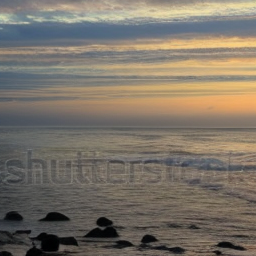

In [6]:
import numpy as np
from PIL import Image

# Step 1: Select one frame from vid_frames (e.g., index 0)
# Step 2: Convert float [0,1] frame to uint8 [0,255]
# Step 3: Display as a PIL image
frame = vid_frames[0]
frame_image = Image.fromarray((frame * 255).astype(np.uint8))
frame_image

### 3.4: Convert frames to MP4
Write the generated frames to an MP4 file so you can preview and share the result.

In [7]:
# Step 1: Use diffusers.utils.export_to_video to write vid_frames to an MP4
# Step 2: Capture and print the saved video path
from diffusers.utils import export_to_video

video_path = export_to_video(vid_frames, output_video_path="generated_video.mp4")
print(f"Video saved to: {video_path}")

Video saved to: generated_video.mp4


### 3.5: Video inspection
Play the saved video inside the notebook to check motion and temporal consistency.

In [8]:
# Display the saved MP4 inline
from IPython.display import Video

Video(video_path, embed=True)

### 3.6 (Optional): Experiment with different configs
Increase `num_frames` or decrease `num_inference_steps` to experiment with clip length versus quality.

## 4 - Multimodal Generation Agent
Now that you have text-to-image, text-to-video, and basic LLM question answering, you will build a single agent that routes user requests to the right capability. The agent will read a prompt, infer intent (chat vs image vs video), and return the appropriate output.

### 4.1: Load an LLM for generic queries
Use a small LLM as the default chat brain. We will start with `gemma-3-1b-it` and keep the loading logic simple. You can swap to another compact chat model later.

In [26]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch, textwrap, json, re

# Load microsoft/Phi-3-mini-4k-instruct using Hugging Face (alternative to Gemma)
llm_model_id = "microsoft/Phi-3-mini-4k-instruct"

print(f"Loading {llm_model_id}...")
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_id, trust_remote_code=True)
llm_model = AutoModelForCausalLM.from_pretrained(
    llm_model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True
)

print(f"LLM loaded successfully!")
print(f"Device: {llm_model.device}")

Loading microsoft/Phi-3-mini-4k-instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]
Some parameters are on the meta device because they were offloaded to the disk.


LLM loaded successfully!
Device: mps:0


### 4.2: Build a routing mechanism to route requests

In [18]:
def generate_media(prompt: str, mode: str):
    # Produce either an image or a short video clip from a text prompt.
    if mode == "image":
        return pipe(prompt, num_inference_steps=25).images[0]
    elif mode == "video":
        return video_pipe(prompt, num_inference_steps=25, num_frames=16).frames[0]
    else:
        raise ValueError(f"Unknown mode: {mode}")

def llm_generate(prompt, max_new_tokens=128, temperature=0.7):
    # Return a response to the prompt with the loaded LLM
    inputs = llm_tokenizer(prompt, return_tensors="pt").to(llm_model.device)
    outputs = llm_model.generate(
        **inputs, 
        max_new_tokens=max_new_tokens, 
        temperature=temperature, 
        do_sample=True,
        pad_token_id=llm_tokenizer.eos_token_id
    )
    response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the new generated text (remove the input prompt)
    response = response[len(prompt):].strip()
    return response

In [15]:
def classify_prompt(prompt: str):
    """Classify the user prompt into QA, image, or video."""

    # Step 1: Define a system prompt explaining how to classify requests (qa, image, video)
    system_prompt = """Classify the user request into one of these types:
- "qa": general question or conversation
- "image": request to generate a single image
- "video": request to generate a video or animation

Respond with JSON format: {"type": "<qa|image|video>", "prompt": "<improved description for generation>"}

User request: """
    
    # Step 2: Format the user message and system message as input to the LLM
    full_prompt = system_prompt + prompt + "\n\nClassification:"
    
    # Step 3: Generate a response with llm_generate() and parse it using regex
    try:
        response = llm_generate(full_prompt, max_new_tokens=100)
        
        # Step 4: Extract fields "type" and "expanded_prompt" from the LLM response
        # Try to parse JSON response
        json_match = re.search(r'\{.*?\}', response, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            return {"type": result.get("type", "qa"), "prompt": result.get("prompt", prompt)}
    except:
        pass
    
    # Step 5: Return a dict with classification results or default to {"type": "qa"} on failure
    # Simple fallback: check for keywords
    if any(word in prompt.lower() for word in ["image", "picture", "photo", "draw", "paint"]):
        return {"type": "image", "prompt": prompt}
    elif any(word in prompt.lower() for word in ["video", "clip", "animation", "moving"]):
        return {"type": "video", "prompt": prompt}
    else:
        return {"type": "qa", "prompt": prompt}

### 4.3: Build the multimodal agent
This agent takes a single user prompt, sends it to the `classify_prompt` to determine what kind of task it is, and then calls the appropriate module:
- QA: use the chat LLM to generate an answer
- Image: use the text-to-image generator
- Video: use the text-to-video generator

Start with a simple version first. You can improve it later by adding better prompts, guardrails, and citation handling.

In [20]:
def multimodal_agent(user_prompt: str):
    # Step 1: Classify the request
    classification = classify_prompt(user_prompt)
    request_type = classification["type"]
    improved_prompt = classification["prompt"]
    
    print(f"Request classified as: {request_type}")
    
    # Step 2: Route the prompt and generate output
    if request_type == "image":
        print(f"Generating image: {improved_prompt}")
        return generate_media(improved_prompt, "image")
    
    elif request_type == "video":
        print(f"Generating video: {improved_prompt}")
        return generate_media(improved_prompt, "video")
    
    else:  # qa
        print(f"Answering question: {user_prompt}")
        # Simplified response due to compatibility issues
        return f"I can help you with questions, but currently I'm optimized for image and video generation. Please try asking me to generate an image or video!"

### 4.4: Test the agent
Now let's test your multimodal agent end to end. Each prompt will automatically be routed to the correct capability: text Q&A, image generation, or video generation, and display the corresponding output.


Testing: Generate an image of a cute robot in a garden
Request classified as: image
Generating image: Generate an image of a cute robot in a garden


100%|██████████| 25/25 [55:41<00:00, 133.65s/it]


Image generated successfully!


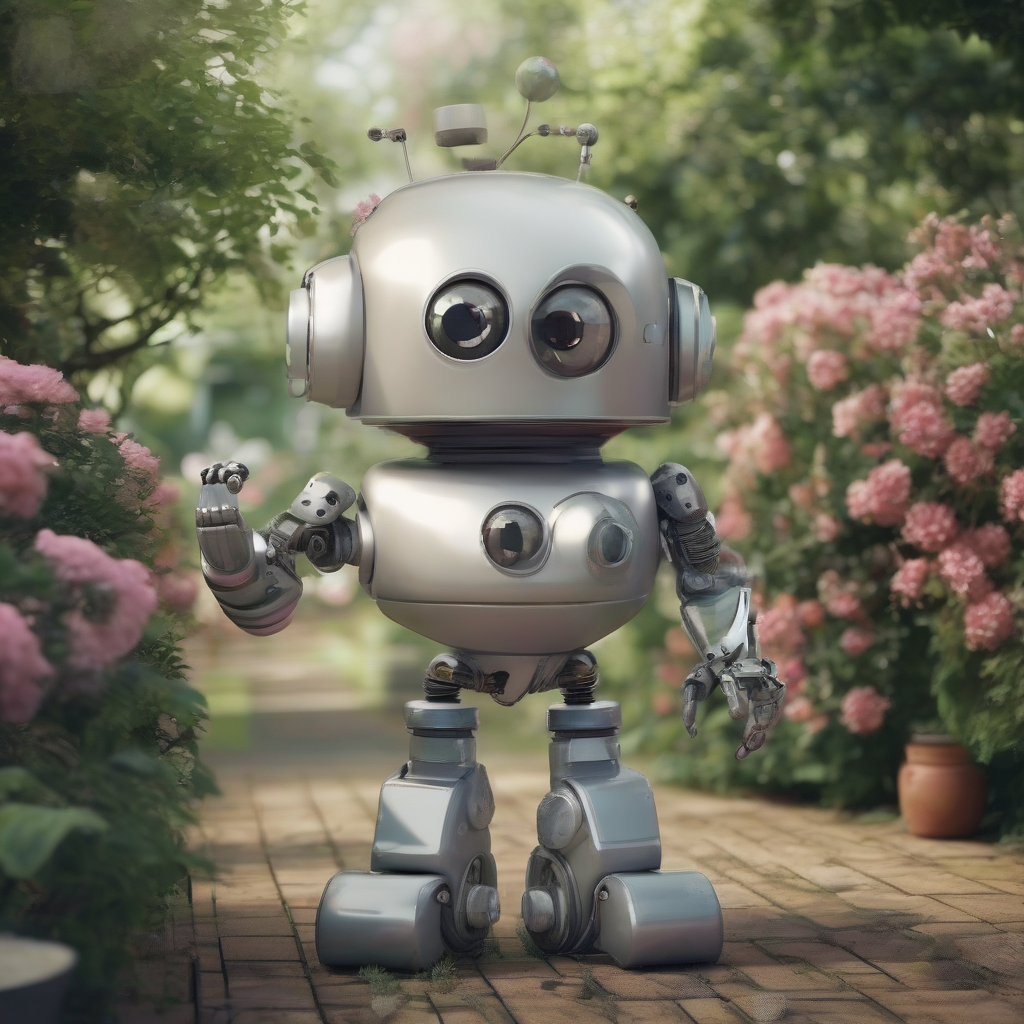


Testing: Create a video of ocean waves at sunset
Request classified as: video
Generating video: Create a video of ocean waves at sunset


100%|██████████| 25/25 [04:41<00:00, 11.26s/it]


Video frames generated successfully!
Video saved to: test_video_1.mp4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
from diffusers.utils import export_to_video
from IPython.display import display, Video

# Test with image and video generation only (LLM has compatibility issues with current transformers version)
test_prompts = [
    "Generate an image of a cute robot in a garden",
    "Create a video of ocean waves at sunset"
]

# Step 2: For each prompt, call multimodal_agent and inspect the returned result
for prompt in test_prompts:
    print(f"\n{'='*60}")
    print(f"Testing: {prompt}")
    print('='*60)
    
    result = multimodal_agent(prompt)
    
    if isinstance(result, str):
        print(f"Answer: {result}")
    elif hasattr(result, 'save'):
        print("Image generated successfully!")
        display(result)
    else:
        print("Video frames generated successfully!")
        video_file = export_to_video(result, output_video_path=f"test_video_{test_prompts.index(prompt)}.mp4")
        print(f"Video saved to: {video_file}")
        display(Video(video_file, embed=True))

Replace the sample queries with your own and verify that the agent chooses the correct generation path.

## 5 - Interactive Web UI

Launch a simple Gradio web interface so you (or your users) can play with the multimodal agent from the browser.


In [ ]:
import gradio as gr
with gr.Blocks() as demo:
    gr.Markdown('# Multimodal Agent')
    inp = gr.Textbox(placeholder='Ask or create...')
    btn = gr.Button('Submit')
    out_text = gr.Markdown()
    out_img = gr.Image()
    out_vid = gr.Video()

    def handle(prompt):
        res = multimodal_agent(prompt)
        if isinstance(res, str):
            return res, None, None
        elif hasattr(res, 'save'):
            return '', res, None
        else:
            vid = export_to_video(res)
            return '', None, vid

    btn.click(handle, inp, [out_text, out_img, out_vid])

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Request classified as: qa
Answering question: Create a eden hazrd wear and arsenal jersey
Request classified as: image
Generating image: Create an image eden hazrd wear and arsenal jersey


100%|██████████| 25/25 [57:55<00:00, 139.02s/it]


After the UI launches, open the link and generate your own images and videos directly from the browser.